NOTE: defining the HOME path constant

In [1]:
import os
HOME = os.getcwd()
print(f'HOME directory path: \'{HOME}\'')

HOME directory path: '/content'


#### Installing required packages

In [2]:
!pip install -r {HOME}/requirements.txt --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.3/896.3 kB 42.1 MB/s eta 0:00:00


### Connecting to Roboflow dataset

In [3]:
import roboflow
roboflow.login(force=True) # Login into roboflow

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········


In [10]:
rf = roboflow.Roboflow()

In [5]:
project = rf.workspace("stormdamagechallenge").project("hurricanedamagev7-f6aoq")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to hurricanedamagev7-1 in yolov8:: 100%|██████████| 11843/11843 [00:02<00:00, 5269.35it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Import remaining packages

In [6]:
import torch

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
from IPython.display import Image

# Progress bar
from tqdm import tqdm

import numpy as np

# Others
import os
import shutil
import zipfile

%matplotlib inline

Check the version of Ultralytics

In [7]:
ultralytics.checks()

Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.0/112.6 GB disk)


In [8]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [9]:
!nvidia-smi

Wed Nov 27 15:16:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Loading Yolov8 model

In [15]:
# Loading the model
model = YOLO('../models/yolov8/yolov8n.pt')
# Display model information (optional)
model.info()

100%|██████████| 6.25M/6.25M [00:00<00:00, 268MB/s]


YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

### Training Model

In [13]:
yaml_file = f'{HOME}/hurricanedamagev7-1/data.yaml'
yaml_file

'/content/hurricanedamagev7-1/data.yaml'

#### Resume model training from last step (optional)

In [11]:
# Resuming model training from last completed epoch
# model = YOLO('runs/detect/train/weights/last.pt')

In [16]:
# Train the model on the dataset for 20 epochs
model.train(data=yaml_file, batch = -1, device=0, epochs=30, patience = 5, time=1, imgsz=512, plots=True)

Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=../models/yolov8/yolov8n.pt, data=/content/hurricanedamagev7-1/data.yaml, epochs=30, time=1, patience=5, batch=-1, imgsz=512, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_

100%|██████████| 755k/755k [00:00<00:00, 89.3MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 357MB/s]


AMP: checks passed ✅


train: Scanning /content/hurricanedamagev7-1/train/labels... 4736 images, 1 backgrounds, 0 corrupt: 100%|██████████| 4736/4736 [00:03<00:00, 1341.43it/s]


train: New cache created: /content/hurricanedamagev7-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=512 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.10G reserved, 0.06G allocated, 14.58G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011628       5.246         0.157         74.09         527.1        (1, 3, 512, 512)                    list
     3011628       10.49         0.226         23.79         46.64        (2, 3, 512, 512)                    list
     3011628       20.99         0.382         70.15         49.96        (4, 3, 512, 512)                    list
     3011628       41.97         0.736         25.37         144.6        (8

train: Scanning /content/hurricanedamagev7-1/train/labels.cache... 4736 images, 1 backgrounds, 0 corrupt: 100%|██████████| 4736/4736 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/hurricanedamagev7-1/valid/labels... 1181 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1181/1181 [00:01<00:00, 654.64it/s]


val: New cache created: /content/hurricanedamagev7-1/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008203125), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 1 hours...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      11.1G      1.373      2.761      1.277        161        512: 100%|██████████| 46/46 [01:09<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.32s/it]


                   all       1181      20917      0.332      0.408      0.313      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/41        15G       1.09      1.386      1.087        226        512: 100%|██████████| 46/46 [01:04<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.04s/it]


                   all       1181      20917       0.38       0.44      0.317      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/43      14.1G      1.012      1.211      1.062        359        512: 100%|██████████| 46/46 [01:07<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


                   all       1181      20917      0.345      0.612      0.357       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/44      11.2G     0.9949      1.158      1.056        285        512: 100%|██████████| 46/46 [01:04<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.33s/it]


                   all       1181      20917      0.373       0.56      0.391       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/44      11.6G     0.9763      1.109      1.047        252        512: 100%|██████████| 46/46 [01:09<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


                   all       1181      20917      0.393      0.586      0.411      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/44      10.8G     0.9482      1.074      1.037        378        512: 100%|██████████| 46/46 [01:03<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<00:00,  1.99s/it]


                   all       1181      20917      0.435      0.555      0.415      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/45      12.1G     0.9294      1.045      1.033        347        512: 100%|██████████| 46/46 [01:04<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:17<00:00,  2.89s/it]


                   all       1181      20917      0.494      0.562      0.516      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/44      11.2G     0.9247      1.022      1.028        393        512: 100%|██████████| 46/46 [00:59<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.32s/it]


                   all       1181      20917      0.494      0.579      0.519      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/45      15.2G     0.9112      1.005      1.027        296        512: 100%|██████████| 46/46 [01:01<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


                   all       1181      20917       0.52      0.605      0.564      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/45      13.3G     0.9045     0.9935      1.025        394        512: 100%|██████████| 46/46 [01:04<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


                   all       1181      20917      0.518      0.615      0.562      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/45      11.1G     0.8967     0.9736      1.021        226        512: 100%|██████████| 46/46 [01:01<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


                   all       1181      20917      0.531      0.597      0.563      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/46      13.4G     0.9119     0.9655      1.024        178        512: 100%|██████████| 46/46 [01:05<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


                   all       1181      20917      0.552      0.613      0.611      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/46      11.8G     0.8883     0.9626      1.015        355        512: 100%|██████████| 46/46 [01:02<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


                   all       1181      20917      0.545      0.604      0.578      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/46      13.7G     0.8725     0.9424       1.01        351        512: 100%|██████████| 46/46 [01:02<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.32s/it]


                   all       1181      20917      0.556        0.6      0.602      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/46      14.4G     0.8694     0.9342      1.008        290        512: 100%|██████████| 46/46 [01:01<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<00:00,  1.89s/it]


                   all       1181      20917      0.572      0.628      0.616      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/46      12.9G     0.8682     0.9349      1.005        327        512: 100%|██████████| 46/46 [01:04<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


                   all       1181      20917      0.535      0.626      0.616      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/46      12.7G     0.8543     0.9125      1.004        389        512: 100%|██████████| 46/46 [01:01<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


                   all       1181      20917      0.524      0.623      0.573      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/46      14.4G     0.8586     0.9129      1.005        351        512: 100%|██████████| 46/46 [01:00<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


                   all       1181      20917      0.574      0.638      0.647       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/46      15.1G     0.8573     0.8943     0.9998        326        512: 100%|██████████| 46/46 [01:03<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


                   all       1181      20917      0.566       0.65      0.638      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/46      13.4G      0.847     0.9048      1.001        262        512: 100%|██████████| 46/46 [00:59<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


                   all       1181      20917      0.583      0.629      0.629      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/46      15.1G      0.853     0.8984     0.9983        569        512: 100%|██████████| 46/46 [01:05<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


                   all       1181      20917      0.588      0.631      0.646      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/46      12.9G     0.8412     0.8852     0.9964        339        512: 100%|██████████| 46/46 [01:00<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


                   all       1181      20917      0.566      0.602      0.614      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/46      12.6G     0.8382     0.8801     0.9959        371        512: 100%|██████████| 46/46 [01:00<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


                   all       1181      20917      0.596      0.649      0.659      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/47      11.1G     0.8381      0.878     0.9959        335        512: 100%|██████████| 46/46 [01:04<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:14<00:00,  2.33s/it]

                   all       1181      20917      0.612      0.647      0.665      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/46      13.1G     0.8335     0.8722     0.9946        265        512: 100%|██████████| 46/46 [01:00<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:16<00:00,  2.72s/it]

                   all       1181      20917      0.589      0.628      0.639      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/46      13.4G     0.8308     0.8658     0.9925        243        512: 100%|██████████| 46/46 [01:02<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:10<00:00,  1.81s/it]

                   all       1181      20917      0.575      0.608       0.61      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/47      13.9G     0.8269     0.8558     0.9902        324        512: 100%|██████████| 46/46 [01:02<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<00:00,  1.91s/it]

                   all       1181      20917       0.62      0.666      0.681      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/47      14.5G     0.8211     0.8535     0.9869        253        512: 100%|██████████| 46/46 [01:03<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]


                   all       1181      20917      0.615      0.651      0.668      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/47      13.4G     0.8176     0.8458     0.9858        409        512: 100%|██████████| 46/46 [01:00<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


                   all       1181      20917      0.633      0.649      0.678      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/47      13.4G     0.8171     0.8499     0.9868        304        512: 100%|██████████| 46/46 [01:03<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<00:00,  2.00s/it]


                   all       1181      20917      0.613      0.638      0.661      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/47      12.8G     0.8097       0.84     0.9843        345        512: 100%|██████████| 46/46 [01:00<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


                   all       1181      20917      0.589      0.659      0.669      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/47      15.2G     0.8162     0.8398      0.984        296        512: 100%|██████████| 46/46 [01:00<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


                   all       1181      20917      0.613      0.648      0.675      0.525
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 27, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

32 epochs completed in 0.691 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:24<00:00,  4.09s/it]


                   all       1181      20917      0.623      0.663      0.681      0.534
damagedcommercialbuilding        458        881      0.431      0.528      0.454       0.33
damagedresidentialbuilding        872       3490       0.54      0.713      0.674      0.511
undamagedcommercialbuilding        662       2421      0.674      0.556      0.665      0.529
undamagedresidentialbuilding        892      14125      0.847      0.855       0.93      0.765
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ec38c650100>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

/content


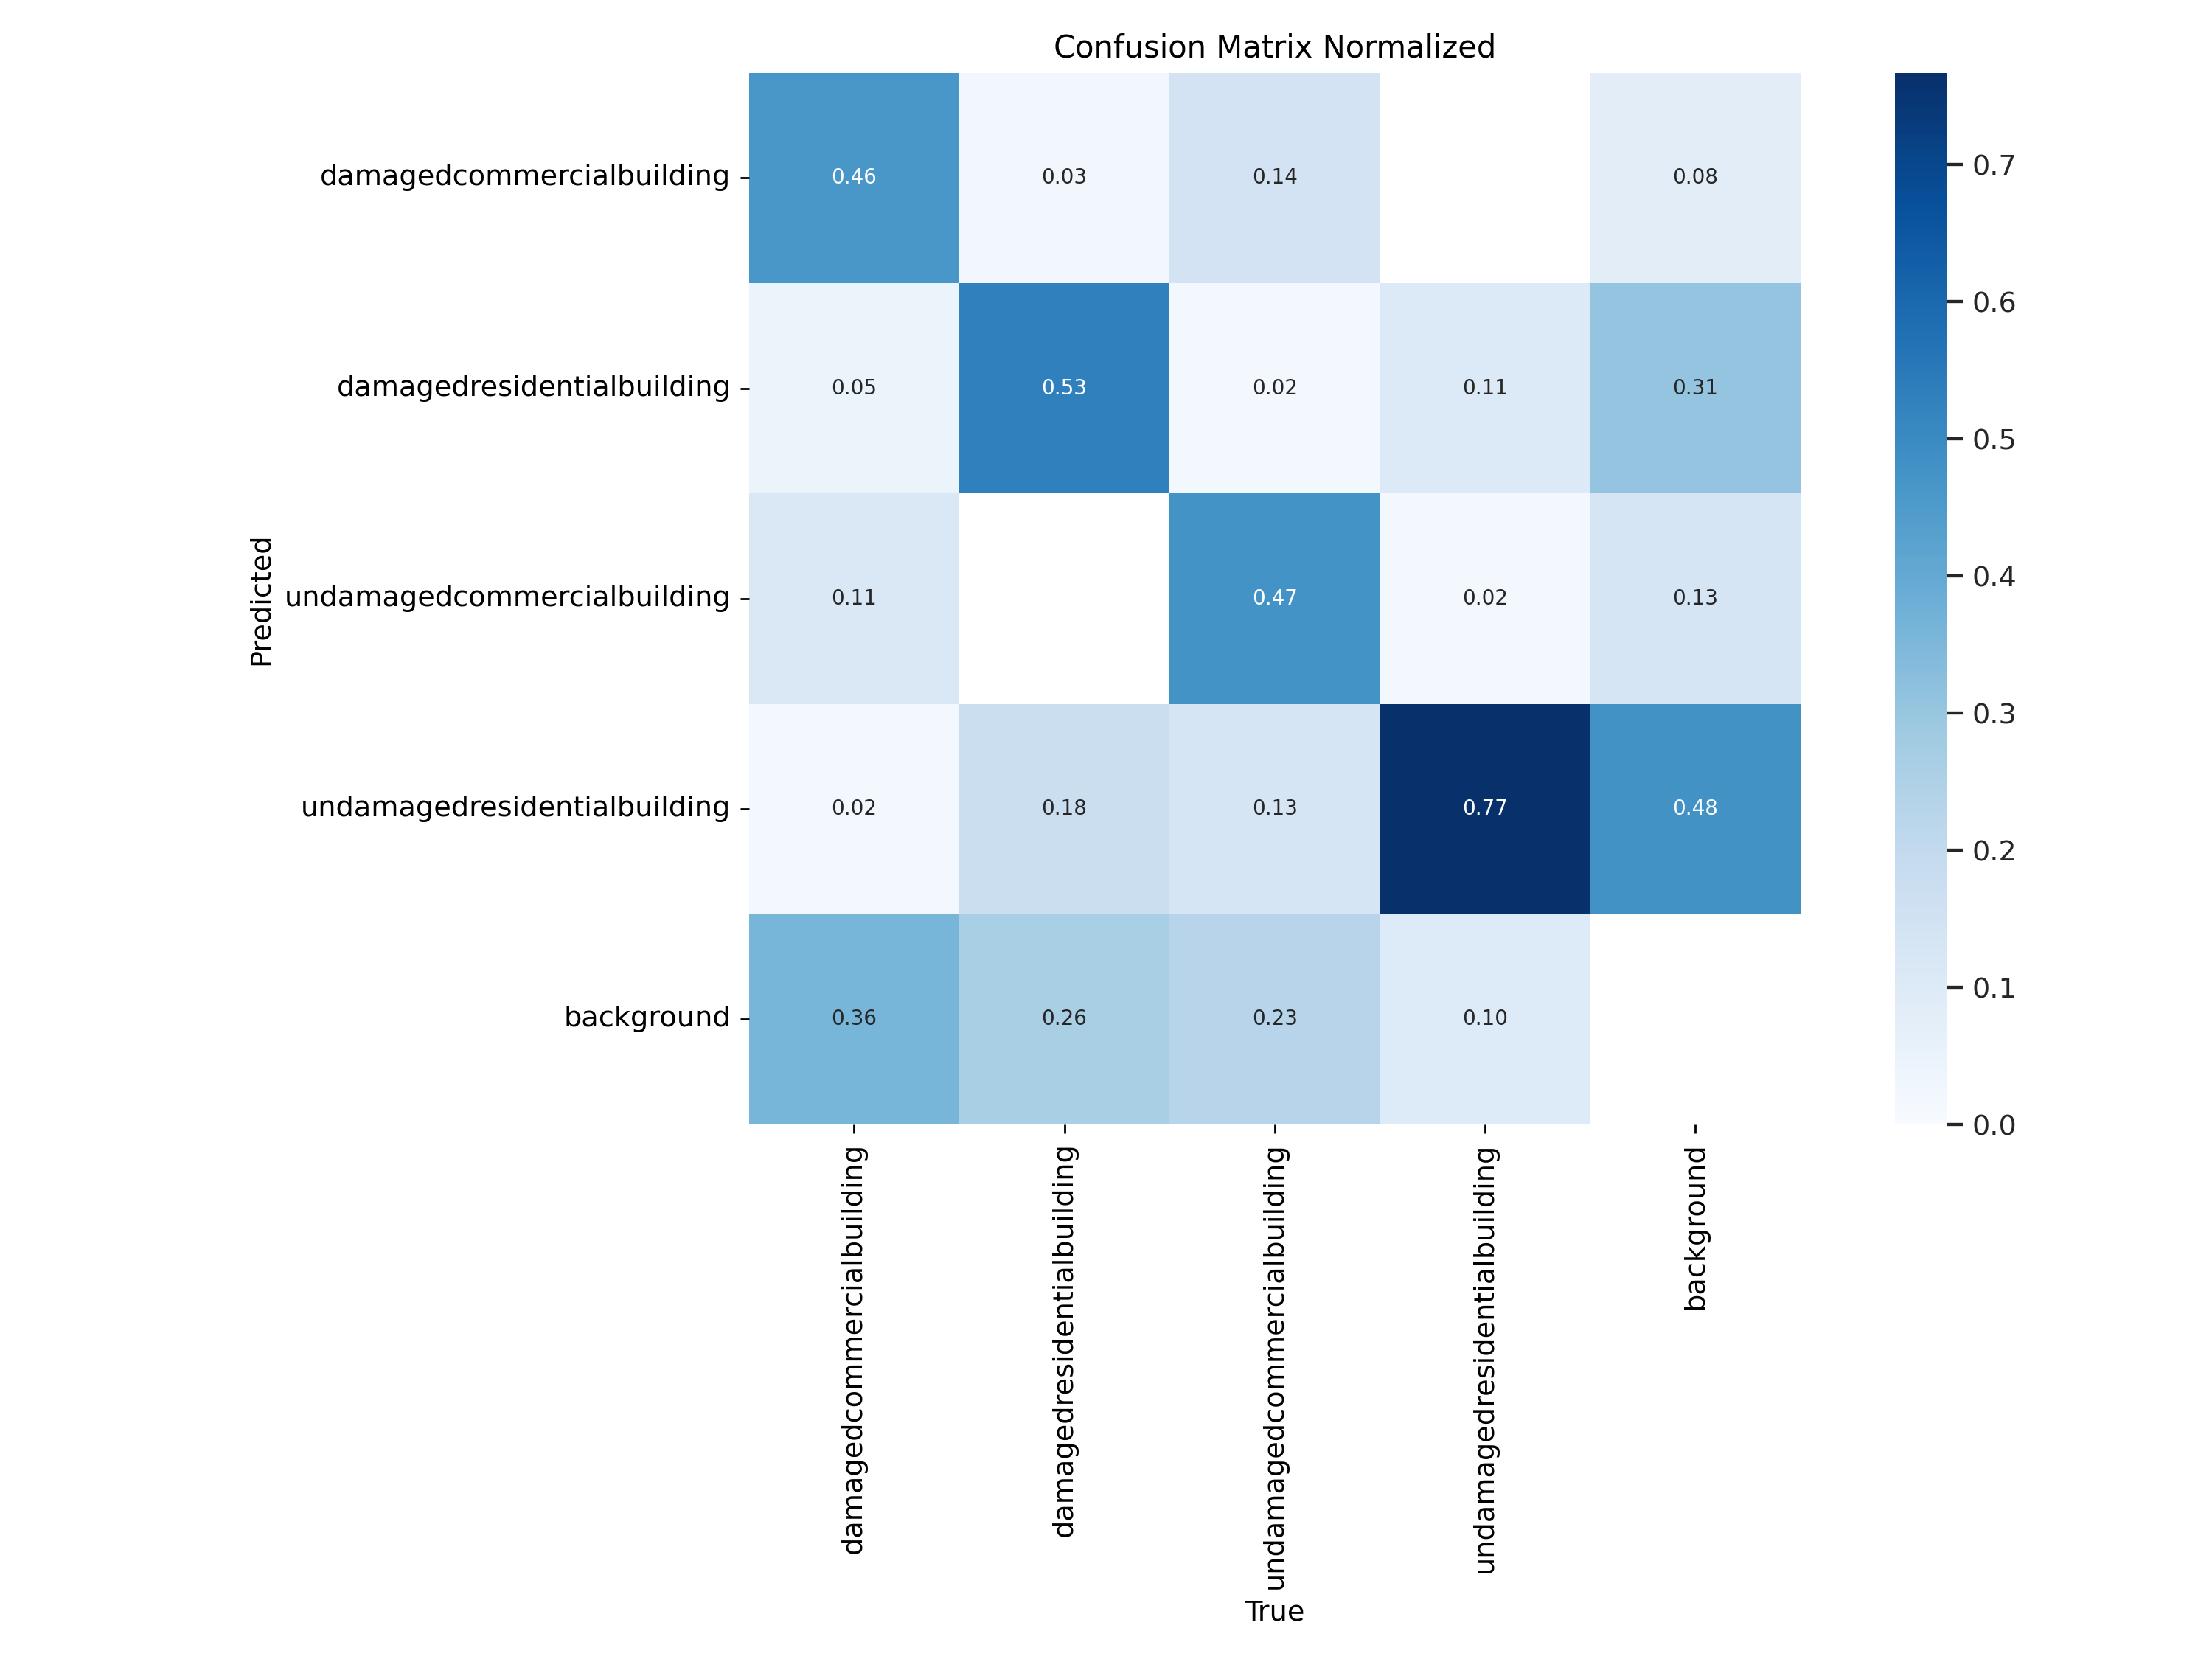

In [17]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix_normalized.png', width=600) # FIRST RUN: 20 epochs

/content


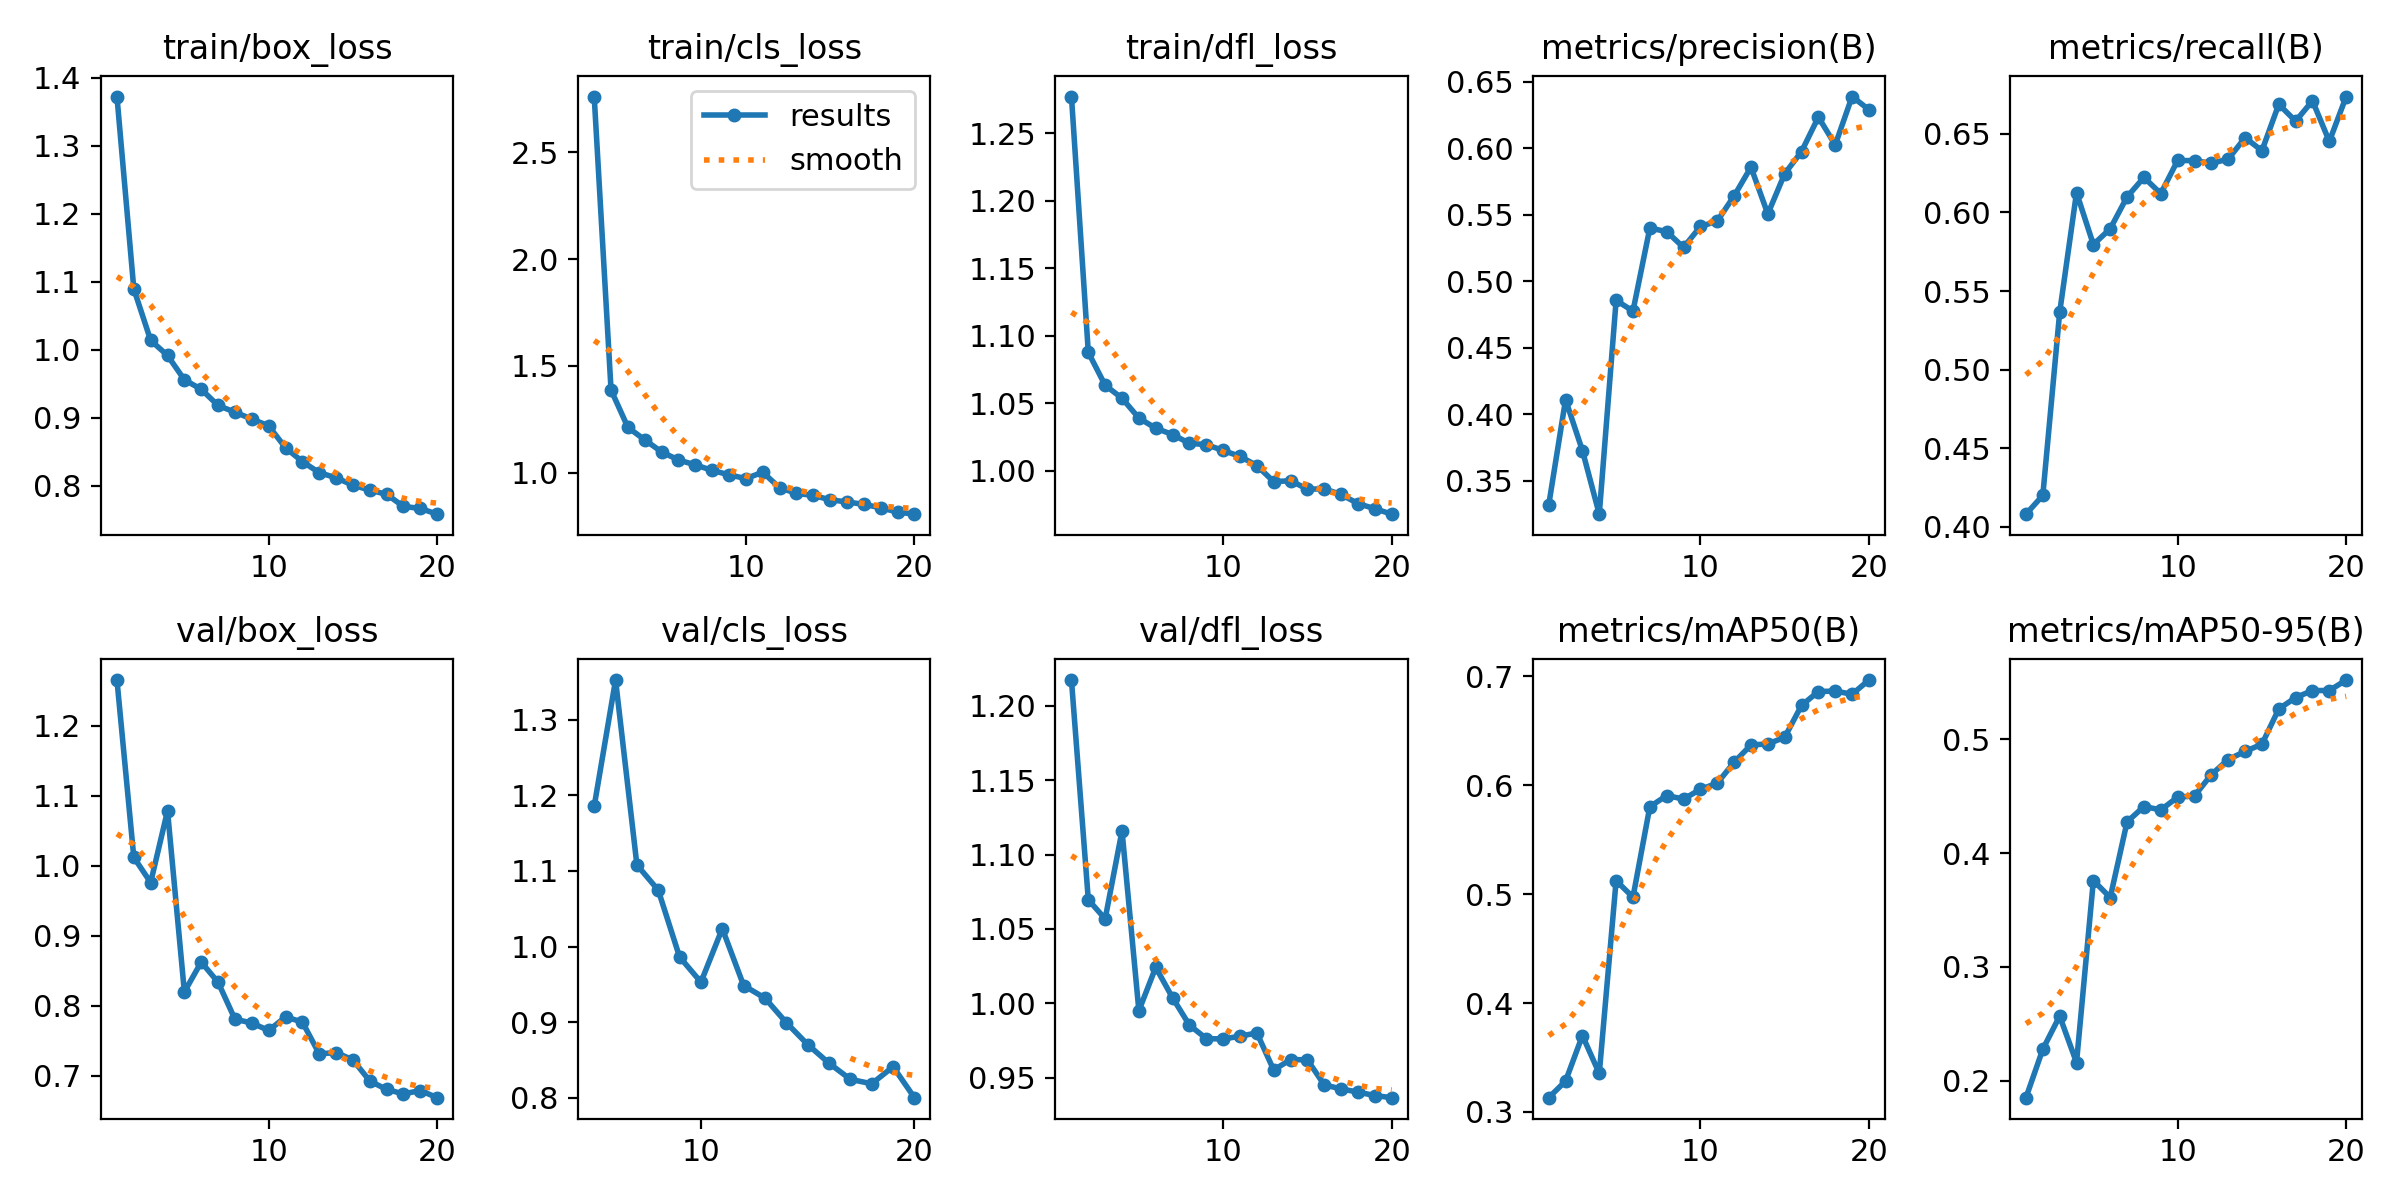

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


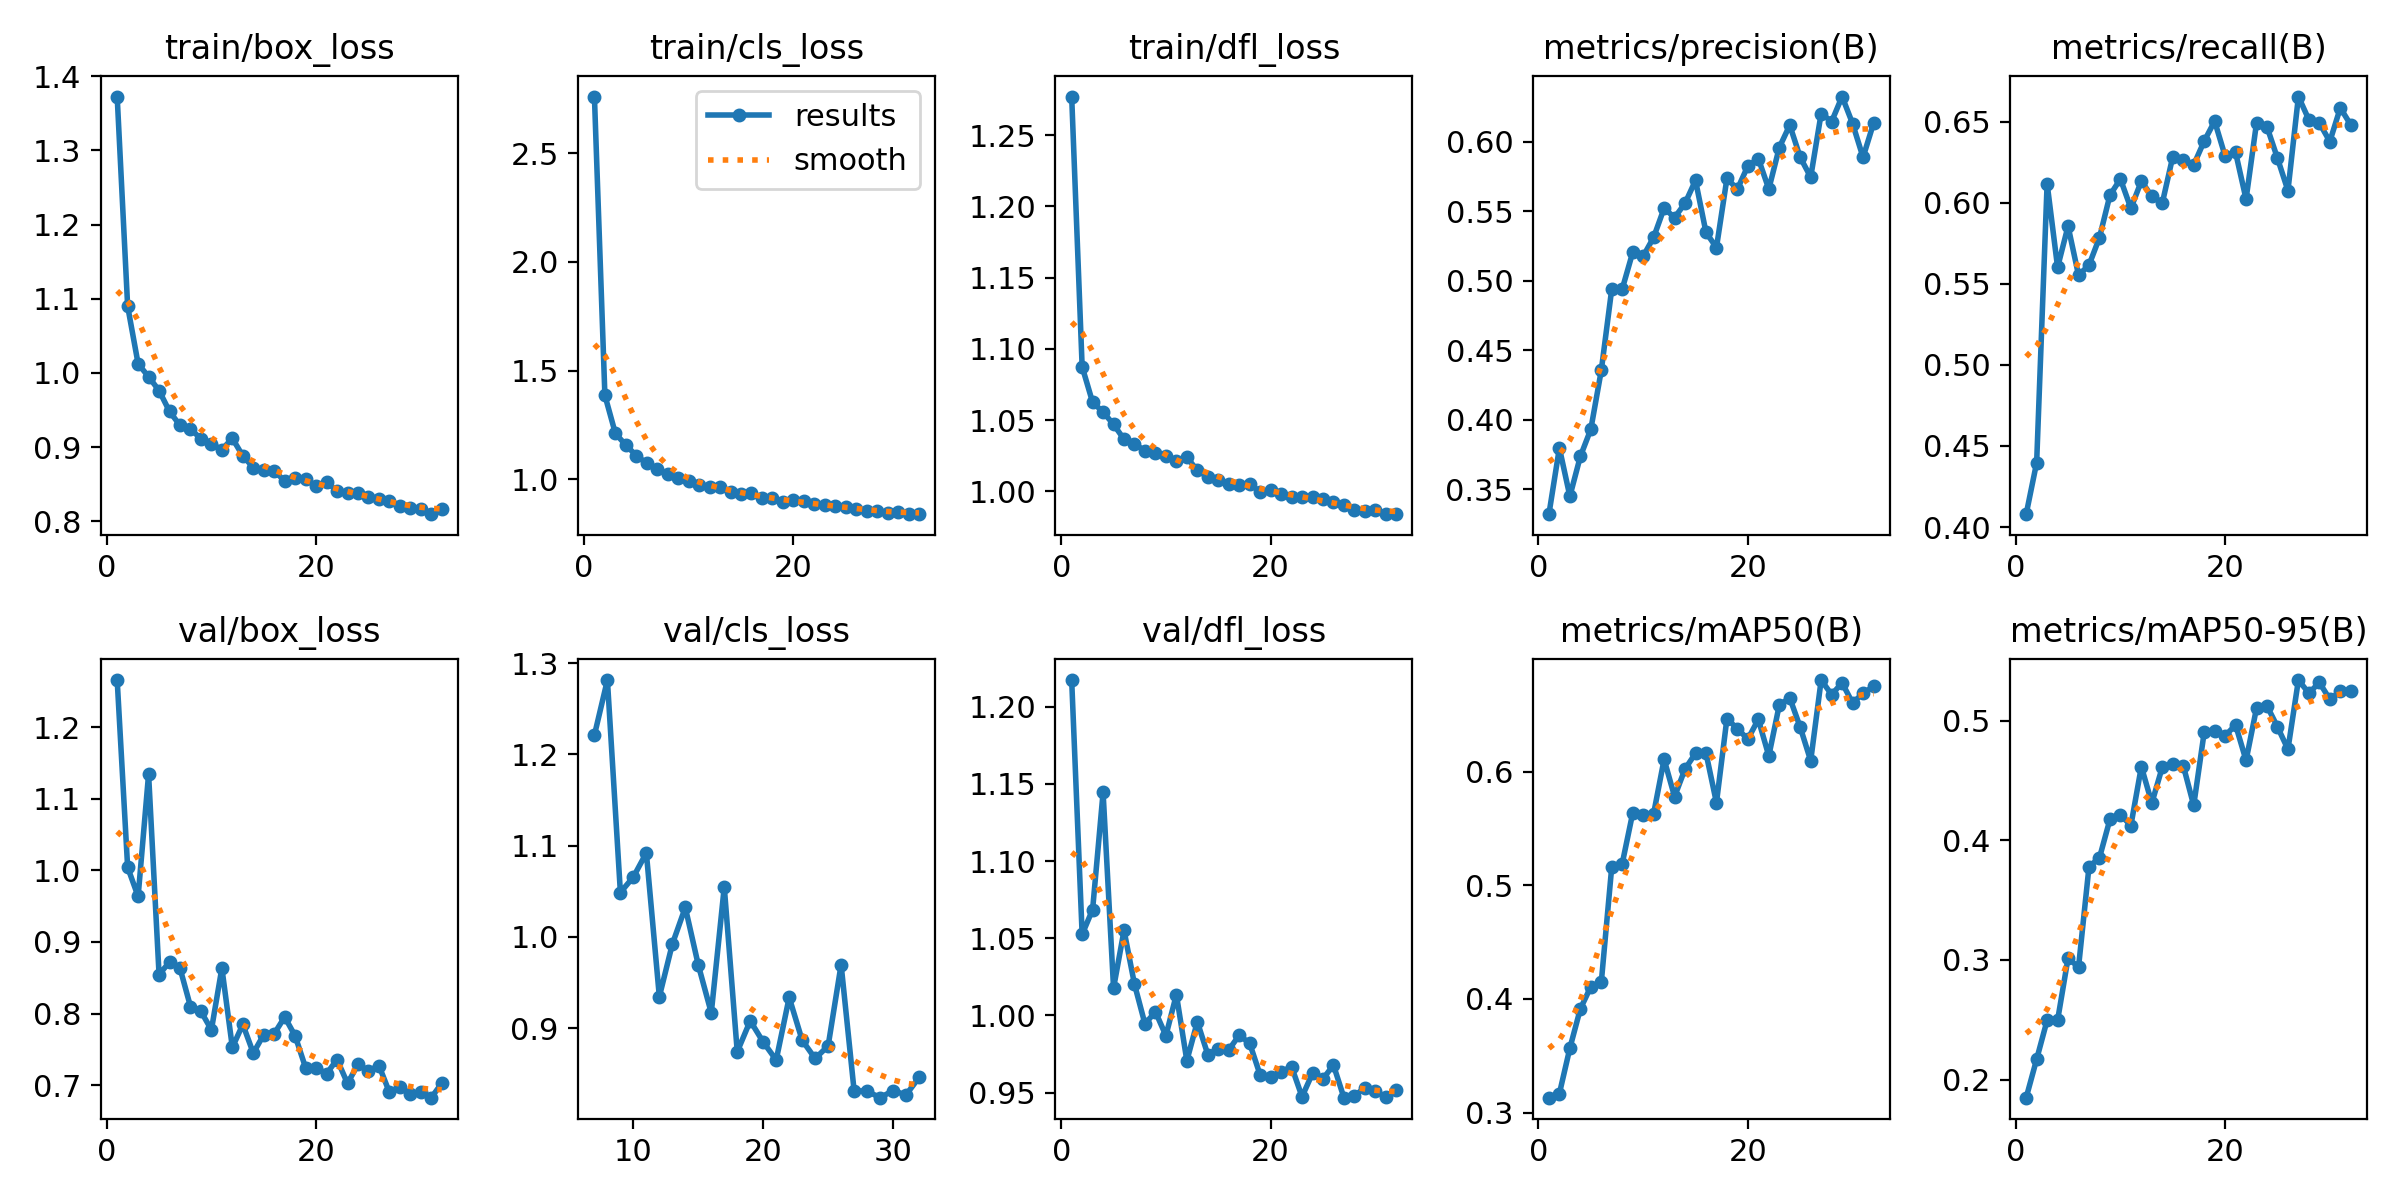

In [20]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

## Loading Training Datasets

Mound google drive which contains the required training dataset

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Check internet speed (optional)

In [ ]:
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

Retrieving speedtest.net configuration...
Testing from Google Cloud (34.126.168.143)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by PT. Jala Lintas Media (Semarang) [1171.81 km]: 30.175 ms
Testing download speed................................................................................
Download: 263.09 Mbit/s
Testing upload speed......................................................................................................
Upload: 184.19 Mbit/s


Print the current working directory in google collab

In [ ]:
!pwd

/content


Create a new directory for the dataset

In [ ]:
!mkdir data

In [ ]:
!cp -r ../gdrive/MyDrive/Colab\ Notebooks/datasets/hurricanedamagev7.v2i.yolov8.train.valid /content/data